In [1]:
import pandas as pd
import re
from nltk import corpus
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer as wnl
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD, NMF
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
plt.style.use('fivethirtyeight')

## Lemmatizing and Tokenizing, Do not run again

In [ ]:
raw_data = pd.read_json("data/LOCO.json")

In [ ]:
def lemmatize(word):
    lemmatized = wnl().lemmatize(word.lower())
    return word
def tokenize(text):
    new_text = re.sub("[^0-9a-zA-Z]", ' ', text)
    new_list = new_text.lower().split()
    stop = stopwords.words('english')
    words = [x for x in new_list if not x in stop]
    final = [lemmatize(x) for x in words]
    return final

In [ ]:
raw_data["tokens"] = raw_data["txt"].apply(tokenize)

In [ ]:
raw_data["response"] = [1 if  x == "conspiracy" else 0 for x in raw_data["subcorpus"]]

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
x = [None]*len(raw_data["txt"])
for i in range(len(raw_data["txt"])):
     x[i] = sid.polarity_scores(raw_data.iloc[i]["txt"])
raw_data["summary_score"] = [d['compound'] for d in x]

In [ ]:
raw_data= raw_data.drop("txt", axis = "columns")

In [ ]:
raw_data.to_csv("data/LOCO_tokenized.csv")

## EDA

In [2]:
LOCO_data = pd.read_csv("data/LOCO_tokenized.csv", index_col = 0)
LOCO_data["date"] = pd.to_datetime(LOCO_data["date"])

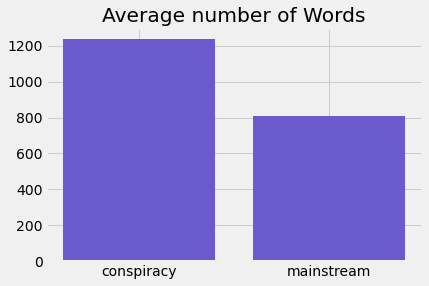

In [3]:
avg_words = LOCO_data.groupby(["subcorpus"])[["txt_nwords"]].mean().reset_index()
plt.bar(avg_words["subcorpus"], avg_words["txt_nwords"], color = "slateblue")
plt.title("Average number of Words")
plt.show()

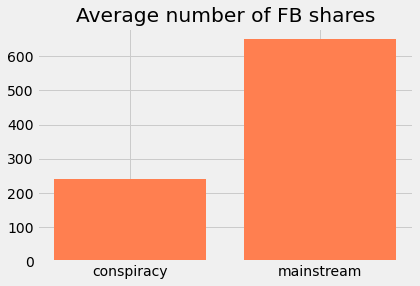

In [4]:
avg_shares = LOCO_data.groupby(["subcorpus"])[["FB_shares"]].mean().reset_index()
plt.bar(avg_shares["subcorpus"], avg_shares["FB_shares"], color = "coral")
plt.title("Average number of FB shares")
plt.show()

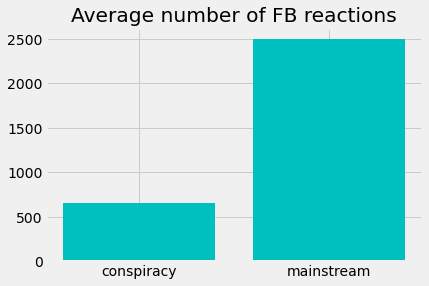

In [5]:
avg_reacts = LOCO_data.groupby(["subcorpus"])[["FB_reactions"]].mean().reset_index()
plt.bar(avg_reacts["subcorpus"], avg_reacts["FB_reactions"], color = "c")
plt.title("Average number of FB reactions")
plt.show()

## Start topic modeling

In [ ]:
y = LOCO_data["response"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(LOCO_data.drop("response", axis = "columns"), 
                                        y, test_size=0.2, random_state=0)

In [ ]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,2))

In [ ]:
X_tr_dtm = cv.fit_transform(X_train["tokens"])

In [ ]:
X_tr_dtm.shape

In [ ]:
X_test_dtm = cv.transform(X_test["tokens"])

In [ ]:
nmf = NMF(20)
X_tr_nmf = nmf.fit_transform(X_tr_dtm)
X_test_nmf = nmf.transform(X_test_dtm)

In [ ]:
topic_term = nmf.components_.round(3)

In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [ ]:
output = display_topics(nmf, cv.get_feature_names(), 10)

### Rename Columns

In [ ]:
X_test_nmf = pd.DataFrame(X_test_nmf)
X_test_nmf.columns = ["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5","Topic 6","Topic 7","Topic 8",
                               "Topic 9","Topic 10","Topic 11","Topic 12","Topic 13","Topic 14","Topic 15","Topic 16",
                               "Topic 17","Topic 18","Topic 19","Topic 20",]
X_test_nmf = X_test_nmf.set_index(X_test.index)
X_test = pd.concat([X_test, X_test_nmf], axis = 1)

In [ ]:
X_tr_nmf = pd.DataFrame(X_tr_nmf)
X_tr_nmf.columns = ["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5","Topic 6","Topic 7","Topic 8",
                               "Topic 9","Topic 10","Topic 11","Topic 12","Topic 13","Topic 14","Topic 15","Topic 16",
                               "Topic 17","Topic 18","Topic 19","Topic 20",]
X_tr_nmf = X_tr_nmf.set_index(X_train.index)
X_train = pd.concat([X_train, X_tr_nmf], axis = 1)

### Prep sets for Modeling

In [ ]:
X_train["response"] = y_train
X_train_model = X_train.drop(["date","doc_id", "URL", "website", "seeds", "subcorpus", "title", "topic_k100", "topic_k200",
                              "topic_k300", "mention_conspiracy", "conspiracy_representative","cosine_similarity", "tokens"], axis = 1)
X_train_model = X_train_model.dropna()
y_train = X_train_model["response"]
X_train_model = X_train_model.drop(["response"], axis = 1)

In [ ]:
X_test["response"] = y_test
X_test_model = X_test.drop(["date","doc_id", "URL", "website", "seeds", "subcorpus", "title", "topic_k100", "topic_k200",
                              "topic_k300", "mention_conspiracy", "conspiracy_representative","cosine_similarity", "tokens"], axis = 1)
X_test_model = X_test_model.dropna()
y_test = X_test_model["response"]
X_test_model = X_test_model.drop(["response"], axis = 1)

### Run an initial Logistic Regression

In [6]:
X_train_model = pd.read_csv("data/X_train.csv", index_col = 0 )
X_test_model = pd.read_csv("data/X_test.csv", index_col = 0 )
y_train = pd.read_csv("data/y_train.csv", index_col = 0 )
y_test = pd.read_csv("data/y_test.csv", index_col = 0 )

In [7]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train_model, y_train)

/home/marcel/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [8]:
pred = lr.predict(X_test_model)

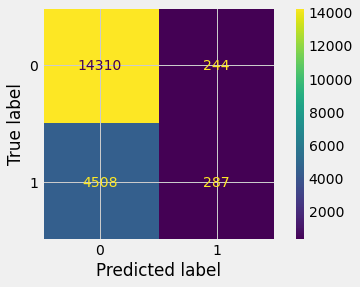

In [9]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=lr.classes_)
disp.plot()
plt.show()

### Run an Initial RFC

In [10]:
rfc = RandomForestClassifier(max_depth=3, n_estimators = 100)
rfc.fit(X_train_model, y_train)

/tmp/ipykernel_30549/2555383984.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train_model, y_train)


RandomForestClassifier(max_depth=3)

In [11]:
pred = rfc.predict(X_test_model)

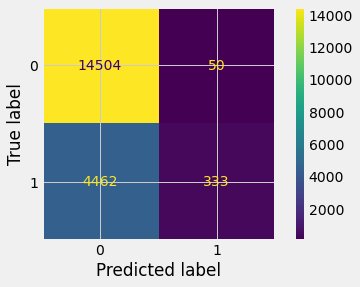

In [12]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=rfc.classes_)
disp.plot()
plt.show()

In [13]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))
print("Precision: {}".format(metrics.precision_score(y_test, pred)))
print("Recall: {}".format(metrics.recall_score(y_test, pred)))
print("F1: {}".format(metrics.f1_score(y_test, pred)))

Accuracy: 0.7668096542456975
Precision: 0.8694516971279374
Recall: 0.06944734098018769
F1: 0.12862108922363846


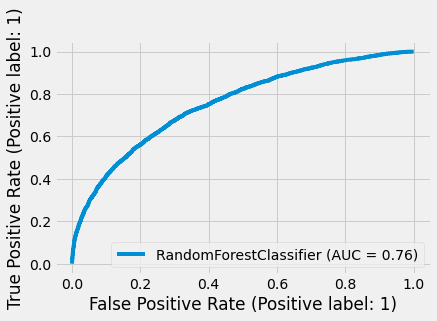

In [14]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rfc, X_test_model, y_test)
plt.show()

<BarContainer object of 27 artists>

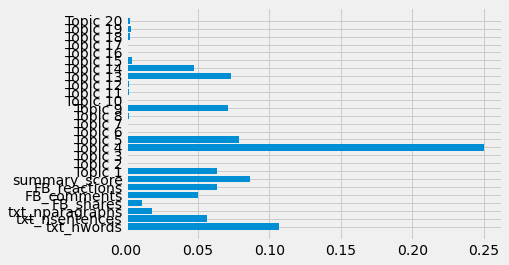

In [15]:
plt.barh(rfc.feature_names_in_,rfc.feature_importances_)

## Try a GridSearchCV to optimize hyperparameters

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [24]:
rf_model = RandomForestClassifier()
params={"max_depth": range(5,20,5), "min_samples_leaf": range(1,15,5),
         "n_estimators":[10,400],'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:4},{0:1,1:6},{0:1,1:8}]}
model_names =  "rf_model"
parameters_list=[params]
model_log= "_rf"
scaler = StandardScaler()
Grid=GridSearchCV(estimator=rf_model, param_grid=parameters_list, scoring='roc_auc',
                      n_jobs=-1, cv=3, verbose=3)
    
model=Grid.fit(X_train_model,y_train.values.ravel())

Fitting 3 folds for each of 90 candidates, totalling 270 fits


In [25]:
final_model= model.best_estimator_
final_model

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=15,
                       n_estimators=400)

In [26]:
model.best_score_

0.8703451104215539

In [27]:
rfc2 = RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=15,
                       n_estimators=400)
rfc2.fit(X_train_model, y_train.values.ravel())
#pred = rfc2.predict(X_test_model)

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=15,
                       n_estimators=400)

In [28]:
pred_probs = rfc2.predict_proba(X_test_model)

In [29]:
pred = [1 if prob[1] >= 0.4 else 0 for prob in pred_probs]

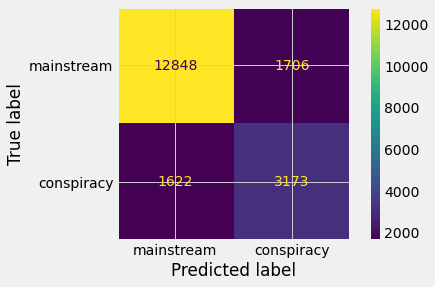

In [30]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["mainstream","conspiracy"])
disp.plot()
plt.show()

In [31]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))
print("Precision: {}".format(metrics.precision_score(y_test, pred)))
print("Recall: {}".format(metrics.recall_score(y_test, pred)))
print("F1: {}".format(metrics.f1_score(y_test, pred)))

Accuracy: 0.8280014471032094
Precision: 0.6503381840541095
Recall: 0.6617309697601669
F1: 0.6559851147405418


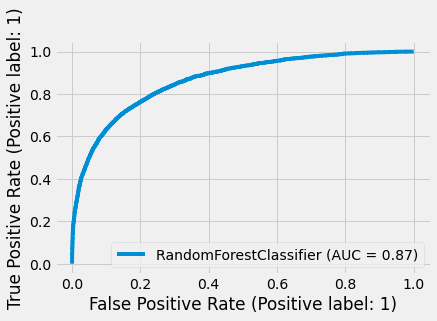

In [32]:
RocCurveDisplay.from_estimator(rfc2, X_test_model, y_test)
plt.show()

<BarContainer object of 27 artists>

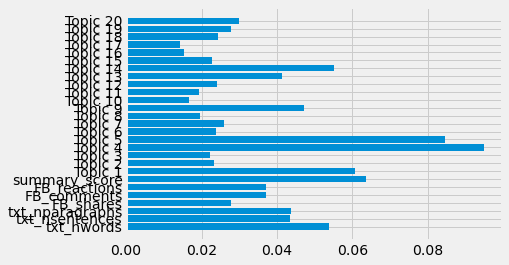

In [34]:
plt.barh(rfc2.feature_names_in_,rfc2.feature_importances_)

## LR GridSearch not quite as good

In [ ]:
lr_model = LogisticRegression(max_iter=5000)
scaler = StandardScaler()
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
Grid = GridSearchCV(estimator = lr_model,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
    
model=Grid.fit(X_train_model,y_train)
        

In [ ]:
model.best_score_